# gd_newton_bfgs三种方法比较

梯度下降法： [0.99999403 0.99998803]
梯度下降法迭代次数： 13062
梯度下降法梯度范数 7.096053008546764e-06
牛顿法： [0.99999013 0.99998002]
牛顿法迭代次数： 109
牛顿法梯度范数 9.334291681875793e-05
bfgs极小值为[0.99999997 0.99999993],函数值为5.663716219581853e-13
bfgs迭代次数为: 128
bfgs梯度范数 1.292939000822939e-06


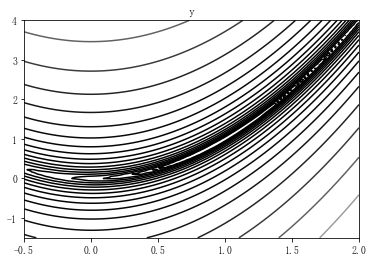

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols,diff


#绘制等值线图
rosenbrockfunction=lambda x,y:(1-x)**2+100*(y-x**2)**2
X,Y=np.meshgrid(np.linspace(-0.5,2,100),np.linspace(-1.5,4,100))
Z=rosenbrockfunction(X,Y)
plt.contour(X,Y,Z,np.logspace(-0.5,3.5,20,base=10),cmap='gray')
plt.title('x')
plt.title('y')

#函数表达式
fun = lambda x:100*(x[0]**2 - x[1]**2)**2 +(x[0] - 1)**2

#梯度向量
gfun = lambda x:np.array([400*x[0]*(x[0]**2 - x[1]) + 2*(x[0] - 1),-200*(x[0]**2 - x[1])])

#求解问题
def BLS(f,df,xk,alpha,pk):
    t=0.55
    c=1e-4
    f_k=f.subs(zip(x,xk))
    df_k=[df[0].subs(zip(x,xk)),df[1].subs(zip(x,xk))]
    while f.subs(zip(x,xk+alpha*pk))>f_k+c*alpha*np.dot(df_k,pk):
        alpha=alpha*t
    return alpha

#梯度下降法
def gd(x0,alpha0,f,df):
    k=0
    xk=x0
    data_x1=[x0[0]]
    data_x2=[x0[1]]
    alpha=alpha0
    alpha_save=[alpha]
    df_k=[df[0].subs(zip(x,xk)),df[1].subs(zip(x,xk))]
    df_k=np.array(df_k,dtype=np.float64)
    while np.linalg.norm(df_k)>1e-5:
        pk=[-1/np.linalg.norm(df_k)]*df_k
        alpha=BLS(f,df,xk,alpha,pk)
        alpha_save.append(alpha)
        xk=xk+alpha*pk
        k=k+1
        data_x1.append(xk[0])
        data_x2.append(xk[1])
        df_k=[df[0].subs(zip(x,xk)),df[1].subs(zip(x,xk))]
        df_k=np.array(df_k,dtype=np.float64)
        #print(data_x1,data_x2,k)   
   # m=np.arange(k)    
    return data_x1,data_x2,k,alpha_save

#牛顿法
def Newton(x0,alpha0,f,df,hess):
    k=0
    xk=x0
    data_x1=[x0[0]]#x
    data_x2=[x0[1]]#y
    alpha=alpha0
    alpha_save=[alpha]
    df_k=[df[0].subs(zip(x,xk)),df[1].subs(zip(x,xk))]
    df_k=np.array(df_k,dtype=np.float64)
    hess_k=[[hess[0,0].subs(zip(x,xk)),hess[0,1].subs(zip(x,xk))],[hess[1,0].subs(zip(x,xk)),hess[1,1].subs(zip(x,xk))]]
    hess_k=np.array(hess_k,dtype=np.float64)
    while np.linalg.norm(df_k)>1e-4:
        pk=np.dot(-1*np.linalg.inv(hess_k),df_k)
        alpha=BLS(f,df,xk,alpha,pk)
        alpha_save.append(alpha)
        xk=xk+alpha*pk
        k=k+1
        data_x1.append(xk[0])
        data_x2.append(xk[1])
        df_k=[df[0].subs(zip(x,xk)),df[1].subs(zip(x,xk))]
        df_k=np.array(df_k,dtype=np.float64)
        hess_k=[[hess[0,0].subs(zip(x,xk)),hess[0,1].subs(zip(x,xk))],[hess[1,0].subs(zip(x,xk)),hess[1,1].subs(zip(x,xk))]]
        hess_k=np.float64(hess_k)
        #print(data_x1,data_x2,k)
    return data_x1,data_x2,k,alpha_save

def bfgs(fun,gfun,x0):
    #功能：用BFGS族算法求解无约束问题：min fun(x) 优化的问题请参考文章开头给出的链接
    #输入：x0是初始点，fun,gfun分别是目标函数和梯度，hess为Hessian矩阵
    #输出：x,val分别是近似最优点和最优解,k是迭代次数  
    maxk = 500
    rho = 0.55
    sigma = 0.4
    gama = 1
    epsilon = 1e-5
    k = 0
    n = len(x0)
    #海森矩阵可以初始化为单位矩阵
    Bk = np.eye(n) #np.linalg.inv(hess(x0)) #或者单位矩阵np.eye(n)
    while np.linalg.norm(gfun(x0))>epsilon:
        gk = gfun(x0)
        #if np.linalg.norm(gk) < epsilon:
            #break
        dk = -1.0*np.linalg.solve(Bk,gk)
        m = 0
        mk = 0
        while m < 20: # 用Wolfe条件搜索求步长
            gk1 = gfun(x0 + rho**m*dk)
            if fun(x0+rho**m*dk) < fun(x0)+sigma*rho**m*np.dot(gk,dk) and np.dot(gk1.T, dk) >=  gama*np.dot(gk.T,dk):
                mk = m
                break
            m += 1
        #BFGS校正
        x = x0 + rho**mk*dk
        #print("第"+str(k)+"次的迭代结果为："+str(x))
        sk = x - x0
        yk = gfun(x) - gk   
        if np.dot(sk,yk) > 0:
        #for i in range(34):
            Bs = np.dot(Bk,sk)
            ys = np.dot(yk,sk)
            sBs = np.dot(np.dot(sk,Bk),sk)
            Bk = Bk - 1.0*Bs.reshape((n,1))*Bs/sBs + 1.0*yk.reshape((n,1))*yk/ys
        k += 1
        x0 = x
    return x0,fun(x0),k#分别是最优点坐标，最优值，迭代次数 

    
if __name__=="__main__":
    #初始化
    x1=symbols('x1')
    x2=symbols('x2')
    x=[x1,x2]
    x0=[-1.2,1]#初始值
    alpha0=1

    #求解最终解和迭代次数
    f=100*(x2-x1**2)**2+(1-x1)**2
    df=[diff(f,x1),diff(f,x2)]
    hess=np.array([[diff(df[0],x1),diff(df[0],x2)],[diff(df[1],x1),diff(df[1],x2)]])
    
    #梯度下降法
    data_x1_s,data_x2_s,k_s,alpha_s=gd(x0,alpha0,f,df)
    X_s=[data_x1_s[-1],data_x2_s[-1]]
    X_s=np.array(X_s)
    print("梯度下降法：",X_s)
    print("梯度下降法迭代次数：",k_s)
    #print("norm(x-x*):",np.linalg.norm(X_s-np.array([1,1])))
    print("梯度下降法梯度范数",np.linalg.norm(gfun(X_s)))
    
    #牛顿法
    data_x1_n,data_x2_n,k_n,alpha_n=Newton(x0,alpha0,f,df,hess)
    X_n=[data_x1_n[-1],data_x2_n[-1]]
    X_n=np.array(X_n)
    print("牛顿法：",X_n)
    print("牛顿法迭代次数：",k_n)
    #print("norm(x-x*):",np.linalg.norm(X_n-np.array([1,1])))
    print("牛顿法梯度范数",np.linalg.norm(gfun(X_n)))
    
    #bfgs
    x0 ,fun0 ,k = bfgs(fun,gfun,np.array(x0))
    print("bfgs极小值为{},函数值为{}".format(x0,fun0))
    print("bfgs迭代次数为:",k)
    print("bfgs梯度范数",np.linalg.norm(gfun(x0)))  